# <center> COMP 562 : Inroduction to Machine Learning </center>
## <center> <font color='red'>Lecture 8 : Naive Bayes Classifier, Tuning and Evaluating Models </font> </center> 
### <center> Mahmoud Mostapha </center> 
### <center> Department of Computer Science -- UNC Chapel Hill</center>
###  <center> September 24, 2018 </center>

# COMP 562 – Lecture 8

Plan for today

1. Review Generative models for classification
2. Naive Bayes with continous feature distribution
4. Naive Bayes with discrete feature distribution
3. Tuning and evaluating models

$$
\renewcommand{\xx}{\mathbf{x}}
\renewcommand{\yy}{\mathbf{y}}
\renewcommand{\zz}{\mathbf{z}}
\renewcommand{\vv}{\mathbf{v}}
\renewcommand{\bbeta}{\boldsymbol{\mathbf{\beta}}}
\renewcommand{\mmu}{\boldsymbol{\mathbf{\mu}}}
\renewcommand{\ssigma}{\boldsymbol{\mathbf{\sigma}}}
\renewcommand{\reals}{\mathbb{R}}
\renewcommand{\loglik}{\mathcal{LL}}
\renewcommand{\penloglik}{\mathcal{PLL}}
\renewcommand{\likelihood}{\mathcal{L}}
\renewcommand{\Data}{\textrm{Data}}
\renewcommand{\given}{ | }
\renewcommand{\MLE}{\textrm{MLE}}
\renewcommand{\tth}{\textrm{th}}
\renewcommand{\Gaussian}[2]{\mathcal{N}\left(#1,#2\right)}
\renewcommand{\norm}[1]{\left\lVert#1\right\rVert}
\renewcommand{\ones}{\mathbf{1}}
\renewcommand{\diag}[1]{\textrm{diag}\left( #1 \right)}
\renewcommand{\sigmoid}[1]{\sigma\left(#1\right)}
\renewcommand{\myexp}[1]{\exp\left\{#1\right\}}
\renewcommand{\mylog}[1]{\log\left\{#1\right\}}
\renewcommand{\argmax}{\mathop{\textrm{argmax}}}
$$

# Multivariate Gaussian Distribution -- Dependent Case

Suppose we have $p$ standard random variables  (0 mean, unit variance)

$$
\begin{aligned}
z_i \sim& \Gaussian{0}{1},&  i=1,\dots p
\end{aligned}
$$

and we are given a vector $\mmu$ of length $n$ and a full-rank matrix $A$ of size $p \times p$

Distribution of $\xx = A\zz + \mu$ is
$$
p(\xx) = \left(2\pi\right)^{-\frac{p}{2}}(\det{\Sigma})^{-\frac{1}{2}}\myexp{\frac{1}{2}(\xx - \mmu)^T\Sigma^{-1}(\xx-\mmu)}
$$
where $\Sigma = AA^T$.

* $\mu$ is **mean** of the Gaussian
* $\Sigma$ is **covariance** matrix


# Maximum Likelihood Estimates of Mean and Covariance

Given data $\{\xx_i \in \reals^N|i=1,\dots,N\}$ maximum likelihood estimates (MLE) of mean and covariance are:

$$
\begin{aligned}
\mmu^{\MLE} &= \frac{1}{N}\sum_{i=1}^N \xx_i\\
\Sigma^{\MLE} & = \frac{1}{N}\sum_{i=1}^N \underbrace{\left(\xx_i - \mmu^{\MLE}\right)\left(\xx_i - \mmu^{\MLE}\right)^T}_{\textrm{ a matrix of size $p \times p$}}
\end{aligned}
$$

Dimensionality
* $\mmu^{\MLE}$ is of same dimension as a single data point $p \times 1$.
* $\Sigma^{\MLE}$ is a matrix of size $p \times p$ 

Note that $\xx\xx^T$ and $\xx^T\xx$ are not the same, former is a matrix, latter is a scalar


# Generative Models for Classification 

There are two ways to factorize joint probability of labels and features

$$
p(y,\xx\given\theta) = p(y\given\xx,\theta)p(\xx\given\theta) =  p(\xx\given y,\theta)p(y\given\theta) 
$$

The second one given us a simple process to *GENERATE* data:

1. First select label according $p(y\given\theta)$, say it was $c$
2. Now generate features $p(\xx\given y=c,\theta)$

Once we have such a model we can obtain the conditional probability $p(y\given\xx)$ using Bayes rule

$$
p(y=c\given \xx) = \frac{p(y=c\given\theta)p(\xx\given y=c,\theta)}{\sum_k p(y=k\given\theta)p(\xx\given y=k,\theta)}
$$

and we can predict label for a new feature vector $\xx$ 

# Generative Models for Classification 

In order to specify a generative model we have to specify its parts

1. Prior probability for a label $p(y\given\theta)$
2. Probability for features in each of the classes $p(\xx\given y=1,\theta),...,p(\xx\given y=k,\theta)$.

**<font color='red'> Q: How would you specify probability of labels? What would be your guess? Can you learn that probability? </font>**

**<font color='red'> Q: Let's say that we have $p$ features and $C$ classes give a guess about the number of parameters need to specify $p(\xx\given y,\theta)$ </font>**

# Generative Models for Classification 

We will make a simplifying assumptions about feature distribution

$$
p(\xx\given y,\theta) = \prod_j p(x_j \given y, \theta)
$$

**<font color='red'> Q: What does this say about features? Recall what it means to be able to factorize $p(x_1,x_2) = p(x_1)p(x_2)$ </font>**

This assumption underlies the **Naive Bayes** method

# Naive Bayes

$$
\begin{aligned}
p(y = c \given \pi ) &= \pi_c \\
p(\xx \given y=c, \theta) &= \prod_j p(x_j \given y= c,\theta_{j,c})
\end{aligned}
$$
Parameters are 
* $\pi_c$ prior probability that a sample comes from the class $c$
* $\theta_{j,c}$ parameters for the $j^\tth$ feature for class $c$

In general, there are many variants of Naive Bayes, you can choose different distributions for $p(x_j \given y = c)$
* Gaussian -- continuous features
* Bernoulli -- binary features
* Binomial -- count of positive outcomes
* Categorical -- discrete features
* Multinomial -- count of particular discrete outcomes

# Naive Bayes with Gaussian Features

We will assume that 

$$
\begin{aligned}
x_j\given y_c, \theta &\sim \Gaussian{\theta_{j,c}}{\sigma^2}
\end{aligned}
$$

Each feature is Gaussian distributed around class specific mean and with shared spherical variance

Let's take a look at the data we generated earlier and read-off these parameters

In [1]:
import numpy
import matplotlib.pyplot as plt

def generate_data(N,d,K,proby,mus,A):
    # This function will generate data from 
    # K Gaussians. Each Gaussian has different mean
    # mus[:,c] is mean for the c-th Gaussian
    # Covariance Sigma = A^T A is shared between 
    # Gaussians.
    ys = [0]*N
    xs = numpy.zeros((d,N))
    for i in range(N):
        # Sample class according to the prior p(y)
        # in this case it is uniform
        ys[i] = numpy.random.choice(K,1)      
        # Sample feature values according to p(x|y)
        # In this case, x ~ N(mmu[y[i]],sigma2*I)
        # To accomplish this, draw z1,z2 ~ N(0,I)    
        z = numpy.random.randn(2,1)
        # transform by matrix A and shift by class mean
        x = numpy.dot(A,z) + mus[:,ys[i]]  
        xs[:,i] = x[:,0]
    return xs,ys

def plot_sample(xs,ys,mus=None,colors=['r','g','b']):
    K = numpy.max(ys)+1
    colors = ['r','g','b']
    for c in range(K):
        # indices of samples assigned to class c
        ind = [i for i in range(N) if ys[i]==c]
        plt.plot(xs[0,ind],xs[1,ind],colors[c]+'.',label='Samples in class '+str(c))    
        if not mus is None:
            plt.plot(mus[0,c],mus[1,c],'kx',markersize=9,markeredgewidth=5)
            plt.plot(mus[0,c],mus[1,c],'wx',markersize=7,markeredgewidth=3)
    plt.legend(loc=2, bbox_to_anchor=(1,1))

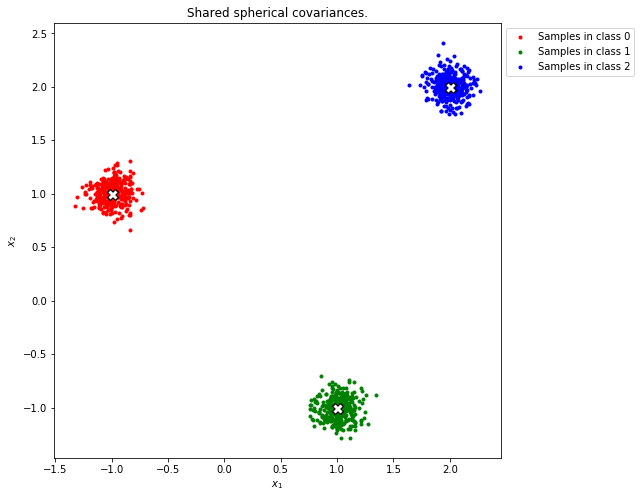

In [3]:
N = 1000 # 100 samples
K = 3   # 3 classes
d = 2   # x is 2d 
proby = [1.0/K]*K # [1./3. , 1./3., 1./3.]
mus = 1.0*numpy.asarray([[-1.0,1.0,2],[1.0,-1.0,2.0]])
sigma = 0.1 # standard deviation, variance is 0.01
A = sigma*numpy.eye(2) # A just scales each coordinate by sigma
xs,ys = generate_data(N,d,K,proby,mus,A)
fig = plt.figure(figsize=(8, 8))
plot_sample(xs,ys,mus)
plt.title('Shared spherical covariances.');
plt.xlabel('$x_1$')
plt.ylabel('$x_2$');

# Learning Parameters for Naive Bayes

In the synthetic data examples, we know the ground truth parameters -- after all, we generated the data

**<font color='red'> Q: How do we go about learning parameters for a Naive Bayes model? </font>**

**joint** Log-likelihood

$$
\begin{aligned}
\loglik(\theta,\pi\given\yy,X) & = \sum_i \log p(y_i,\xx_i\given\theta,\pi)  && \textrm{definition of likelihood} \\
& = \sum_i \log p(y_i\given\pi) + \log p(\xx_i\given y_i,\theta) && \textrm{factorization } p(y,\xx) = p(y) p(\xx|y) \\
& = \sum_i \log p(y_i\given\pi) + \log \prod_j p(x_{j,i}\given y_i,\theta_j) && \textrm{ Naive Bayes assumption}\\
& = \sum_i \log p(y_i\given\pi) + \sum_j \log p(x_{j,i}\given y_i,\theta_j)
\end{aligned}
$$

Note that we have not yet used our assumptions about distribution of $x_{j,i}$

# Learning parameters for Naive Bayes with Gaussian features

**joint** Log-likelihood

$$
\begin{aligned}
\loglik(\theta,\pi\given\yy,X)  &= \sum_i \left[\log p(y_i\given\pi) + \sum_j \log p(x_{j,i}\given y_i,\theta_j) \right]\\
& = \sum_i \left[\log \pi_{\color{red}{y_i}} + \sum_j \log \frac{1}{\sqrt{2\pi\sigma^2}}\myexp{-\frac{1}{2\sigma^2}(x_{j,i} - \theta_{j,\color{red}{y_i}})^2}\right]\\
& = \sum_i \left[\log \pi_{\color{red}{y_i}} - \frac{1}{2} \sum_j \log (2\pi\sigma^2) - \frac{1}{2\sigma^2} \sum_j (x_{j,i} - \theta_{j,\color{red}{y_i}})^2\right]
\end{aligned}
$$

Note that parameters $\pi_c$ and $\theta_{i,c}$ are only used for samples that belong to class $c$ ($y_i=c$)

Hence, we can learn of parameters for each class separately

# Learning Parameters for Naive Bayes with Gaussian Features

Closed form estimates for parameters are

$$
\begin{aligned}
\pi_c &= \frac{\sum_i [y_i = c]}{\sum_i 1} && \textrm{frequency of class $c$ in training data}\\
\theta_{j,c} &= \frac{\sum_i [y_i = c]x_{i,j}}{\sum_i [y_i = c]} && \textrm{average of feature $j$ among samples in class $c$}\\
\sigma &= \frac{\sum_i (x_{j,i} - \theta_{j,y_i})^2}{\sum_i 1}&& \textrm{variance across all features}
\end{aligned}
$$

Note $[x]$ is an indicator function, defined as

$$
  [x] =
  \begin{cases}
    1 & \text{if $x$ is true} \\
    0 & \text{otherwise}
  \end{cases}
$$

# Class Prediction using Naive Bayes with Gaussian Features

Recall that 
$$
\mathop{\textrm{argmax}}_c p(y=c\given \xx) = 
\mathop{\textrm{argmax}}_c \log  p(y=c\given\theta) + \log p(\xx\given y=c,\theta)
$$

After a little bit more manipulation
$$
\begin{aligned}
\log p(y=c \given \xx,\theta,\pi) 
&= \log \pi_{c} - \sum_j \frac{1}{2\sigma^2}(x_{j,i} - \theta_{j,c})^2 + \textrm{const.} 
\end{aligned}
$$
Predicted class
$$
y^* = \mathop{\textrm{argmax}}_c \log \pi_{c} - \underbrace{\sum_j (x_{j,i} - \theta_{j,c})^2}_{\textrm{distance to class center}} + \textrm{const.}
$$


# Naive Bayes with Discrete Features -- Spam Filtering

**Bag of Words representation**

Review 188_7:
"I'm a **huge** **classic** film **buff**, but am just **getting** in to **silent** **movies**. 
A **lot** of **silent** **films** don't **hold** my **attention**, ..."

Review 196_9:
"... **fans** of the **silent** **era**, with many **cameos**, **adds** to the **overall** **fun** ..."

Converted into a row of word counts

<img src="./Images/Table1.PNG" width="1000" align="center"/>

Converted into a row of word presence/absence

<img src="./Images/Table2.PNG" width="1000" align="center"/>

Features can also be word presence/absence, rather than counts as before

These types of representations are called **bag-of-words**

In your first assignment, we use bag-of-words representation of movie reviews to predict sentiment

# Naive Bayes with Discrete Features -- Spam Filtering

One approach to classifying e-mail spam (1) vs not spam (0) is to construct a Naive Bayes model using a bag-of-words representation

Feature vector $\xx$ is $W$ long vector of word presence absence in an e-mail 

$$
\begin{aligned}
p(y =1 ) &= \pi  &&\textrm{prior probability that message is spam} \\
p(y = 0 ) &= 1-\pi  &&\textrm{prior probability that message is  not spam} \\
p(x_{j}  = 1 \given y=1) &= \theta_{1,j} && \textrm{ probability that word $j$ appears in a spam e-mail} \\
p(x_{j}  = 0 \given y=1) &= 1-\theta_{1,j} && \\
p(x_{j}  = 1 \given y=0) &= \theta_{0,j} && \textrm{ probability that word $j$ appears in non-spam e-mail} \\
p(x_{j}  = 0 \given y=0) &= 1-\theta_{0,j} && 
\end{aligned}
$$

**<font color='red'> Q: What is the size of $\pi$? </font>**

**<font color='red'> Q: What is the size of $\theta$? </font>**

# Naive Bayes with Discrete Features -- Spam Filtering

$$
\begin{aligned}
p(y =1 ) &= \pi  &&\textrm{prior probability that message is spam} \\
p(y =0 ) &= 1-\pi  &&\textrm{prior probability that message is  not spam} \\
p(x_{j}  = 1 \given y=1) &= \theta_{1,j} && \textrm{ probability that word $j$ appears in a spam e-mail} \\
p(x_{j}  = 0 \given y=1) &= 1-\theta_{1,j} && \textrm{ probability that word $j$ is absent in a spam e-mail}\\
p(x_{j}  = 1 \given y=0) &= \theta_{0,j} && \textrm{ probability that word $j$ is absent in non-spam e-mail} \\
p(x_{j}  = 0 \given y=0) &= 1-\theta_{0,j} && 
\end{aligned}
$$

More compactly for math purposes using Bernoulli distribution formulas

$$
\begin{aligned}
p(y) &= \pi^y(1-\pi)^{1-y}\\
p(x_{j}\given y) &= \left[\theta_{1,j}^{x_{j}}(1-\theta_{1,j})^{1-x_{j}}\right]^{y}\left[\theta_{0,j}^{x_{j}}(1-\theta_{0,j})^{1-x_{j}}\right]^{1-y}
\end{aligned}
$$

# Naive Bayes for Spam Filtering -- Joint Log-Likelihood

$$
\begin{aligned}
\loglik(\theta,\pi\given X,\yy)&= \sum_i \left[\log p(y_i\given\pi) + \sum_j \log p(x_{j,i}\given y_i,\theta_j) \right]\\ =& \underbrace{\sum_{i=1}^N}_{\textrm{samples}} \left[ y_i\log \pi + (1-y_i)\log (1-\pi) \right] + \underbrace{\sum_{i=1}^N}_{\textrm{samples}} \underbrace{\sum_{j=1}^W}_{\textrm{words}} y_i x_{i,j}\log\theta_{1,j} \\
+& \underbrace{\sum_{i=1}^N}_{\textrm{samples}} \underbrace{\sum_{j=1}^W}_{\textrm{words}} y_i (1-x_{i,j})\log(1-\theta_{1,j}) + \underbrace{\sum_{i=1}^N}_{\textrm{samples}} \underbrace{\sum_{j=1}^W}_{\textrm{words}} (1-y_i) x_{i,j}\log(\theta_{0,j}) \\
+& \underbrace{\sum_{i=1}^N}_{\textrm{samples}} \underbrace{\sum_{j=1}^W}_{\textrm{words}} (1-y_i) (1-x_{i,j})\log(1-\theta_{0,j}) 
\end{aligned}
$$

Work out derivatives and updates for $\pi$, $\theta_{0,j}$, and $\theta_{1,j}$ on the board

# Naive Bayes for Spam Filtering -- Learning

Given a training data with $N$ labeled e-mails, training a Naive Bayes spam model is accomplished using

$$
\begin{aligned}
\pi &= \frac{\sum_{i=1}^N [y_i = 1]}{N} && \textrm{frequency of spam e-mail in the training data}\\
\theta_{1,j} &=  \frac{\sum_{i=1}^N [y_i=1]x_{i,j}}{\sum_{i=1}^N [y_i=1]} && \textrm{freqency of word $j$ in spam e-mail}\\
\theta_{0,j} &=  \frac{\sum_{i=1}^N [y_i=0]x_{i,j}}{\sum_{i=1}^N [y_i=0]} && \textrm{frequency of word $j$ in non-spam e-mail}\\
\end{aligned}
$$

# Naive Bayes for Spam Filtering -- Prediction

Prediction for a new e-mail given its bag-of-words representation $\xx$

$$
\begin{aligned}
p(y = 1 \given \xx) &= \frac{p(y=1, \xx)}{p(\xx)} = \frac{p(y=1, \xx)}{p(y=1,\xx) + p(y=0,\xx)}
\end{aligned}
$$

If interested only in the most likely label of a message represented by $\xx$

$$
\argmax_c \log p(y=c, \xx) = \argmax_c \log\pi_c + \sum_{j=1}^W  \left[ x_{j}\log\theta_{c,j} + (1-x_{j})\log(1 - \theta_{c,j}) \right]
$$

# Spam filtering -- Smoothing

$$
\begin{aligned}
\pi &= \frac{\sum_{i=1}^N [y_i = 1]}{N} && \textrm{frequency of spam e-mail in the training data}\\
\theta_{1,j} &=  \frac{\sum_{i=1}^N [y_i=1]x_{i,j}}{\sum_{i=1}^N [y_i=1]} && \textrm{freqency of word $j$ in spam e-mail}\\
\theta_{0,j} &=  \frac{\sum_{i=1}^N [y_i=0]x_{i,j}}{\sum_{i=1}^N [y_i=0]} && \textrm{frequency of word $j$ in non-spam e-mail}\\
\end{aligned}
$$

**<font color='red'> Q: What is the value of $\theta_{1,j}$ if the word has never been seen in a spam e-mail in the dataset? Is this a problem? If so, why and how would you fix it? </font>**

Uses Naive Bayes approach with smoothing -- even though a word has not been seen it does not have probability 0

# Hyperparameters

In penalized regression we added ridge term
$$
\loglik(\beta) - \frac{\lambda}{2} \sum_{j>0}\beta_j^2
$$

**<font color='red'> Q: How do we choose $\lambda$? What happens if we try to maximize penalized log-likelihood with respect to $\lambda$? </font>**

**<font color='red'> Q: How do we choose which words to count in our document classifiers? All of them? Do we have enough samples? </font>**

# Hyperparameters

Hyperparameters, unlike parameters, typically constrain the model complexity to avoid overfitting

Overfitting occurs when our performance on training set is optimistic compared to performance on test set

<img src="./Images/tradeoff.png" width="1000" align="center"/>


# How do we Select Hyperparameters?

One approach is to split the dataset into three parts:
1. Training set
2. Validation set
3. Test set

Training subset is used to train models for different settings of hyperparameters
for example $\lambda \in \{0.1,0.001,0.0001..\}$

Validation subset is used to evaluate accuracy of the different models we trained and
select the best model

Test set is used to compute the accuracy of the model selected on validation set

**<font color='red'> Q: Why can't we just report accuracy of the best model on the validation set? </font>**

# How do we Select Hyperparameters if the Dataset is Small?

Splitting data into three parts makes sense on a large dataset, but can hurt your performance on a small dataset

We can't look at the test set during training, but validation set seems to be just sitting around

**<font color='red'> Q: Can we somehow use more of the training and validation data for training? What is the problem of leaving just one sample for validation? </font>**

# The Idea: K-fold Cross-Validation

First take out test data, then split the remaining data into $K$ parts and treat each part as validation while training on the rest

An example of $5$-fold cross validation:

0. Split data into disjoint subsets $\Data = \Data_1 \cup \Data_2 \cup \Data_3 \cup \Data_4 \cup \Data_5$
1. Train on $\Data_2 \cup\Data_3\cup\Data_4\cup\Data_5$ compute $\textrm{Error}_1$ on $\Data_1$ 
2. Train on $\Data_1\cup\Data_3\cup\Data_4\cup\Data_5$ compute $\textrm{Error}_2$ on $\Data_2$ 
3. Train on $\Data_1\cup\Data_2\cup\Data_4\cup\Data_5$ compute $\textrm{Error}_3$ on $\Data_3$ 
4. Train on $\Data_1\cup\Data_2\cup\Data_3\cup\Data_5$ compute $\textrm{Error}_4$ on $\Data_4$ 
5. Train on $\Data_1\cup\Data_2\cup\Data_3\cup\Data_4$ compute $\textrm{Error}_5$ on $\Data_5$ 

Report 
$$
\textrm{CVError} = \frac{\textrm{Error}_1 + \textrm{Error}_2 + \textrm{Error}_3 + \textrm{Error}_4 + \textrm{Error}_5}{5}
$$

# 5-Fold Cross Validation Example

<img src="./Images/cv.png" width="1000" align="center"/>

Note: If we set $K = N$, then we get a method called **leave-one out cross validation**, or **LOOCV**

# K-fold Cross-Validation for Linear Regression

Foreach $i = 1 : K$

1. Set $\color{red}{Test = Set_{i}}$ and $\color{blue}{Trian = \bigcup_{i\neq k} Set_{k}}$
2. Learn $\beta_0$ and $\mathbf{\beta}$ on $\{(\xx_{i},y_{i}): i\in \color{blue}{Train}\}$ using $\alpha$
3. $CVErr_{i}(\alpha) = \sum_{i\in\color{red}{Test}}[(y_i - \beta_0 - {\xx_{i}}^{T}\mathbf{\beta})^2]$

$CVErr(\alpha) = \frac{1}{n} \sum_{k} CVErr_{k}(\alpha)$

**<font color='red'> For K-fold cross validation, what $K$ should be selected? </font>**

* **Larger $K$** means **less bias** towards overestimating the true expected error (as training folds will be closer to the total dataset) but **typically higher variance and higher running time** (as you are getting closer to the limit case: Leave-One-Out CV)
* If cross-validation were averaging independent estimates, then with large $K$, one should see relatively lower variance between models; however, this is not true when training sets are highly correlated, which is what we typically deal with

# Classification Performance -- Confusion Matrix

Say we trained a classifier and want to see how well it works

We can report a single number, accuracy, that tells us how often it is right

However, this hides information about where the classifier fails

Confusion matrix is given by:

<img src="./Images/Table3.png" width="1000" align="center"/>

# Classification Performance -- Prediction Rate

Sensitivity, Recall, or True Positive Rate (TPR) 

$$ 
TPR = \frac{TP}{P} = \frac{TP}{TP + FN} = 1 - FNR
$$

Specificity, Selectivity or True Negative Rate (TNR)

$$ 
TNR = \frac{TN}{N} = \frac{TN}{TN + FP} = 1 - FPR
$$

False Positive Rate (FPR)
$$ 
FPR = \frac{FP}{N} = \frac{FP}{TN + FP} = 1 - TNR
$$

False Negative Rate (FNR)
$$ 
FNR = \frac{FN}{P} = \frac{FN}{TP + FN} = 1 - TPR
$$

These measures are computed from either +ve or -ve group, hence they don't depend on classes balance (prevalence = $\frac{P}{P+N}$)

Precision or Positive Predictive Value (PPV)

$$ 
PPV = \frac{TP}{TP+FP}
$$

Negative Predictive Value (NPV)

$$
NPV = \frac{TN}{TN+FN}
$$

Accuracy (ACC)

$$
ACC = \frac{TP+TN}{P+N} = \frac{TP+TN}{TP + FN + TN + FP} 
$$

These measures are computed from both +ve and -ve groups, hence they depend on classes balance (prevalence = $\frac{P}{P+N}$)

# Classification Performance -- ROC Curves

Predictions are based on a cutoff

$$
p(y=1|\xx)>\tau
$$
where $\tau$ is typically 0.5

This particular cutoff will result in a specific prediction rates; however, you may prefer to tradeoff false positives for false negatives -- health industry does

<img src="./Images/roc.gif"  width="1200" align="center"/>

# Classification Performance -- ROC Curves
<img src="./Images/roc_curve.png"  width="600" align="center"/>

* A good ROC curve – hugs top left corner: high TPR, low FPR
* A bad ROC curve – runs along diagonal: TPR equals the FPR

# Area Under the ROC Curve (AUC)

ROC Curve is good for assessing a single classifier, but less suited to comparing different classifiers

A solution to this is to use the area under the curve (AUC) to describe the curve with a single number

<img src="./Images/roc_curve_2.png"  width="800" align="center"/>


# Probabilistic Interpretation of AUC

**AUC Interpretation:** AUC is the probability of correct ranking of a random "positive"-"negative" pair

* So, given a randomly chosen observation $x_{1}$ belonging to class 1, and a randomly chosen observation $x$ belonging to class 0, the AUC is the probability that the evaluated classification algorithm will assign a higher score to $x$ than to $x_{2}$, i.e., the conditional probability of $p(y=1|x_{1}) > p(y=1|x_{2})$

**AUC Computation:** Among all "positive"-"negative" pairs in the dataset compute the proportion of those which are ranked correctly by the evaluated classification algorithm

$$
\hat{AUC} = \frac{1}{P \times N} \sum_{i = 1}^{P} \sum_{j = 1}^{N} [p(y=1|x_{i}) > p(y=1|x_{j})]
$$



# Today
* Naive Bayes with Gaussian features
* Naive Bayes with Bernoulli features
* Hyperaparameter selection
* K-fold Cross-validation 
* Prediction rates, confusion matrix and ROC curves